In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

import shapefile as shp

%matplotlib inline

filepath = '../input/'

In [2]:
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))

In [3]:
data_files = []

for file in os.listdir():
    if file.endswith(".csv"):
        data_files.append(file)
        
print(data_files)

['accepted_2007_to_2018Q4.csv', 'rejected_2007_to_2018Q4.csv']


In [4]:
accepted_path = "./" + data_files[0]
rejected_path = "./" + data_files[1]

In [5]:
if os.path.isfile(accepted_path) and os.path.isfile(rejected_path):
    print('both paths are valid, you are chilling')
else:
    print('located the accepted loans and rejected loans datasets!')

both paths are valid, you are chilling


In [6]:
acc_df = pd.read_csv(accepted_path)

/home/rohan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
rej_df = pd.read_csv(rejected_path)

# Exploratory Data Analysis Below

In [8]:
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [34]:
rej_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648741 entries, 0 to 27648740
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  float64
 5   Zip Code              object 
 6   State                 object 
 7   Employment Length     object 
 8   Policy Code           float64
dtypes: float64(4), object(5)
memory usage: 1.9+ GB


#### Doing Some Basic Data Cleaning!

In [10]:
rej_df['Debt-To-Income Ratio'] = (rej_df['Debt-To-Income Ratio'].str[:-1].astype(float))

In [11]:
rej_df['Debt-To-Income Ratio'] = (rej_df['Debt-To-Income Ratio']/100)

In [12]:
acc_df['dti'] = acc_df['dti']/100

In [13]:
rej_df.shape

(27648741, 9)

In [14]:
acc_df.shape

(2260701, 151)

# EDA Struct

In [44]:
class EDA:
    def __init__(self, data):
        """ Takes a dataframe as a singular input"""
        self.data = data
            
        self.num_rows, self.num_cols = data.shape
            
    def null_data(self, portion=0.3):
        """
        Input: Float value denoting what portion of data is okay to be undefined
        Output: Columns with most amount of Missing Data
        
        Analyzes how much data is missing in each column
        Returns columns with missing data greater than portion value
        based on portion
        """
        
        try : 
            float(portion)
            res = True
        except :
            print("Not a float")
            res = False
            
        if portion >= 1 or portion <= 0:
            return "Portion value needs to be between 0 and 1!"
        
        
        df = self.data
        
        # get total null counts for each column
        # convert to a dictionary 
        null_counts = df.isnull().sum()

        
        # For each column
        # 1. check if fraction of null values is 
        # greater than threshold
        # 2. save columns that are greater than threshhold in a function
        
        bad_cols = {}
        for name, values in df.iteritems():
            null_portion = null_counts[name] / self.num_rows
            if  null_portion >= portion:
                bad_cols[name] = null_portion
        
        print("Out of %d columns we have %d columns with over %.2f%% of null values"%(self.num_cols, len(bad_cols), portion*100))
        
        return bad_cols        
                
                
                
    def state_analysis(self, column_name=None):
        """ Input: column name which contains the states
            Output: Heatmap of the United States showing counts of
            acceptances or rejections"""
        
        if column_name == None:
            return "Please input column name which includes data about which state applicant was accepted/rejected from"
        
        # import shape file for geopandas mapping
        shp_path = "./states_shape/cb_2018_us_state_20m.shp"
        states = gpd.read_file(shp_path)


        df = self.data
        
        state_stats = {'STUSPS':df[column_name].value_counts().keys(),
                     'state_stats' : df[column_name].value_counts().values}

        state_stats = pd.DataFrame(state_stats)
        states = states.merge(state_stats, on='STUSPS')

        states.plot(column ='state_stats', cmap ='Reds', figsize=[50,50])

        
        return df[column_name].value_counts()
    
    def correlation(self):
        """ 
        Input: n/a
        Output(s):
            Displays a Heatmapped Correlation Matrix
            Returns the Correlation Matrix for the Dataframe
        """
        df = self.data
        corrMatrix = df.corr()
        sns.heatmap(corrMatrix, annot=True)
        plt.show()
        return corrMatrix
    
    def loan_grade(self, column_name=None):
        """ 
        Input: Column Name which Denotes Loan Grade
        Ouptut: Create a Bar chart of Loan Grades Present in the Data Set
        Returns a dictionary about values for each loan grade
        """
        
        if column_name == None:
            return "Please input column name which includes data loan grades"

        
        df = self.data
        
        loan_grades = df[column_name].value_counts()
        
        loan_grades.plot.bar(x="Grade", y="# of Loans", rot=70, title="Number of Loans by Loan Grade");
        
        return loan_grades
    
    def dti_loanAmt(self, dti_col=None, loanAmt_col = None ):
        """ Input: column name which includes debt to income ratio information
            Output: Creates a Scatter Plot between Debt-to-Income Ratio and the Loan Amount
        """
        
        if dti_col == None or loanAmt_col == None:
            return "Please input column name which includes data loan grades and loanAmt"
        
        df = self.data
        
        
        fig, ax = plt.subplots(figsize = (9, 6))
        ax.scatter(df[dti_col], df[loanAmt_col])
        ax.set_yscale('log')
        ax.set_xscale('log')
        
        ax.plot()
        
        return

## Using the EDA Class

In [45]:
eda_acc = EDA(acc_df)
eda_rej = EDA(rej_df)

edarr = [eda_acc, eda_rej]

### Checking for Null Values

In [17]:
# Print how many columns with large portions of missing data and drop them.

null_cols_acc = eda_acc.null_data(0.3)
# acc_df.drop(null_cols_acc.keys(), axis=1, inplace=True)


null_cols_rej = eda_rej.null_data(0.3)
# rej_df.drop(null_cols_rej.keys(), axis=1, inplace=True)

Out of 151 columns we have 58 columns with over 30.00% of null values
Out of 9 columns we have 1 columns with over 30.00% of null values


### Creating Maps for Number of Acceptances and Rejections in Each State
#### The darkest reds indicate the most amount of acceptances or rejections

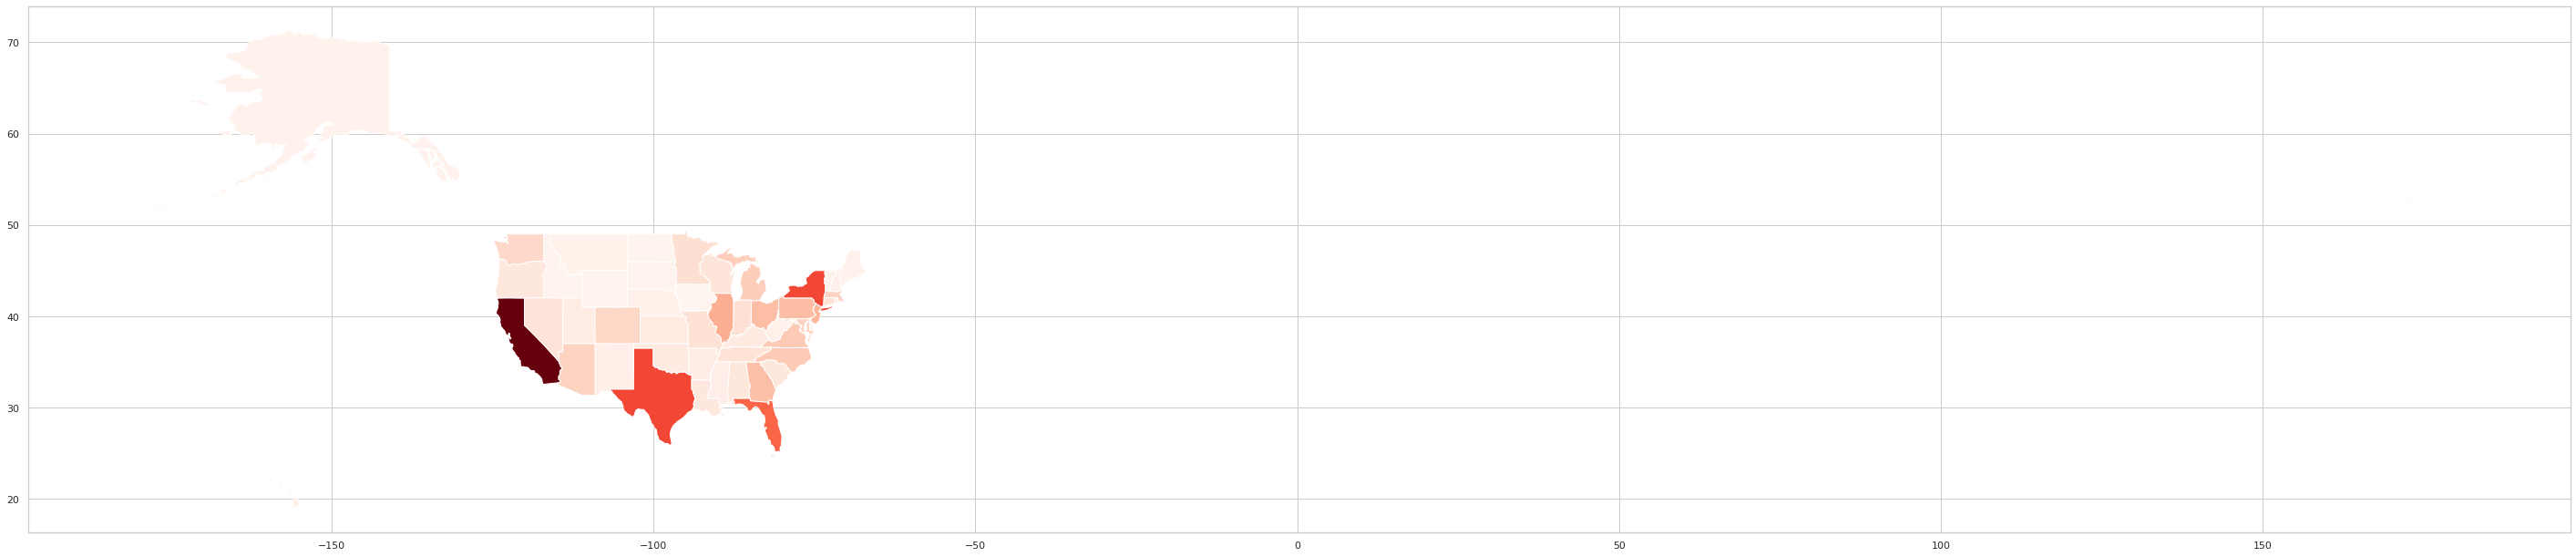

In [18]:
acceptances = eda_acc.state_analysis('addr_state')

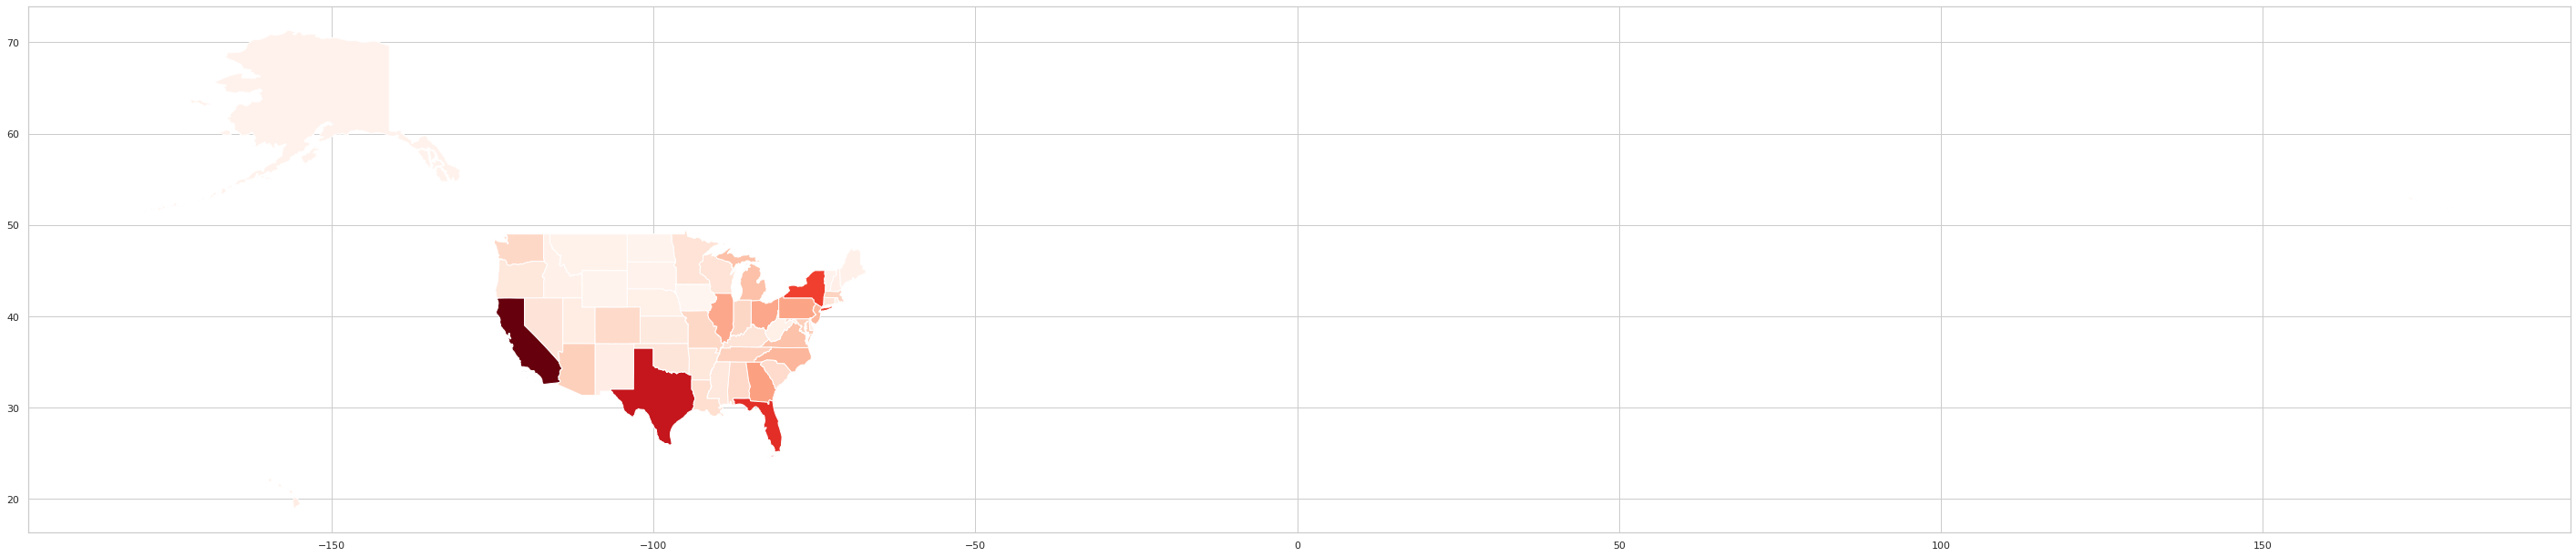

In [19]:
rejections = eda_rej.state_analysis('State')

### Running Correlations for the Various Dataframes

This was unfortunately pretty unhelpful. Fortunately, this was actually pretty easy.

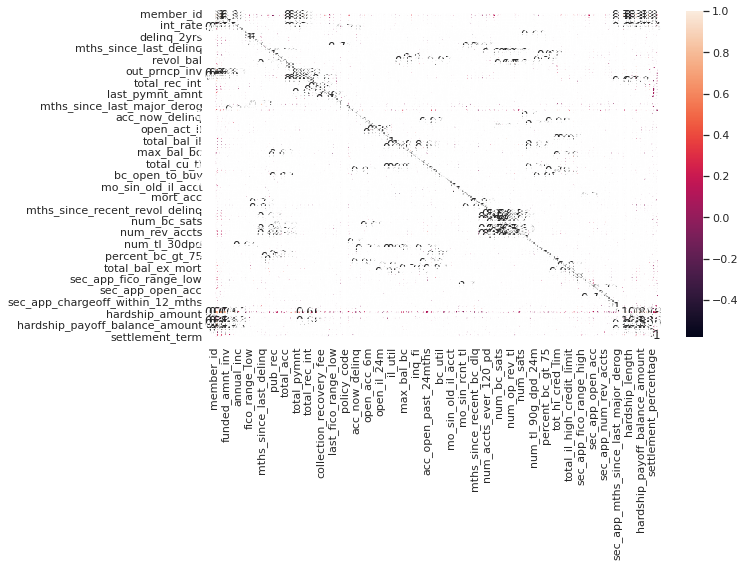

In [20]:
acceptance_correlations = eda_acc.correlation()

This is clearly not helpful.

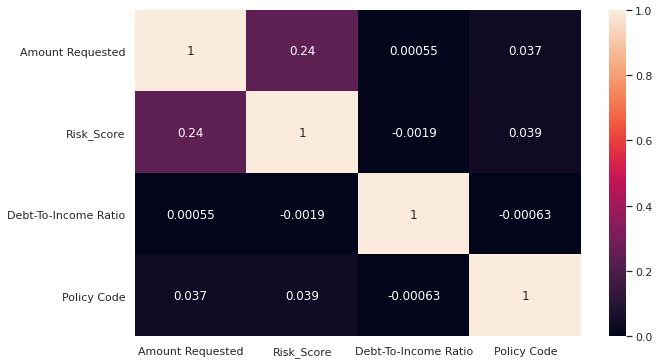

In [21]:
rejction_correlations = eda_rej.correlation()

This is also not very helpful.

### Checking which loan grades are the most common for Accepted Loans

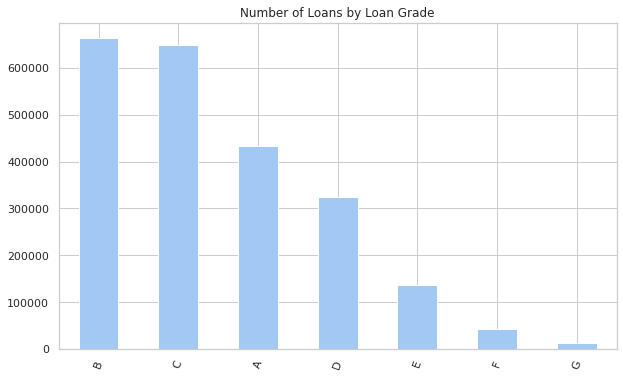

In [22]:
loan_grades = eda_acc.loan_grade('grade')

In [ ]:
### Correlating Debt to Income Ratio:

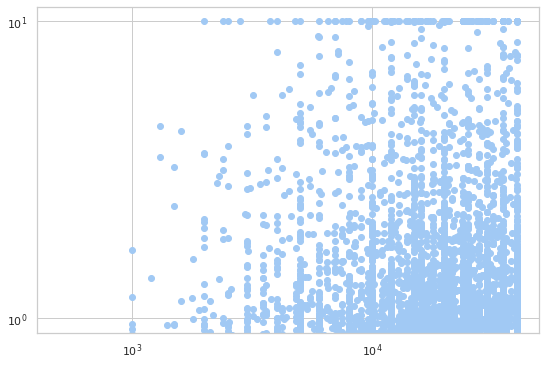

In [46]:
eda_acc.dti_loanAmt('loan_amnt','dti')

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,0.1000,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,0.1000,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,0.1000,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,0.3864,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,0.0943,209xx,MD,< 1 year,0.0


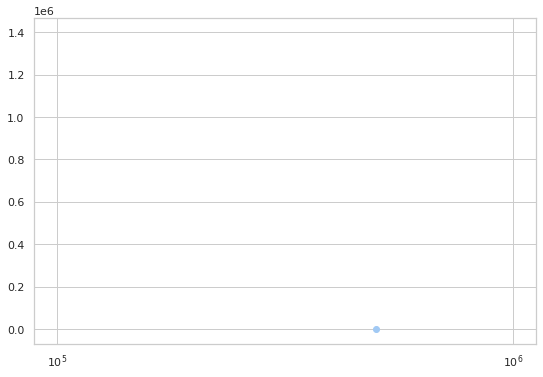

In [38]:
eda_rej.dti_loanAmt('Debt-To-Income Ratio', 'Amount Requested')

## Some Conclusions
### This will be very brief



#### Null Values Function:

With this function, I looked to determine how much of the data was missing and which columns would not effectively aid in the analysis. In the accepted Loans Data Set there were over 50 columns missing 30% or more data.

#### Correlation Matrices

These matrices were ultimately not super helpful because in the accepted data set there were too many columns to gauge any correlations from this. And in the Rejected Dataset, the only values that were somewhat correlated were the Risk_Score and the Amount requested. It's likely that a lower risk score led to higher amounts requested.

#### State Analysis

I graphed the total amount of rejections and acceptances on a state by state basis. And the results for this are pretty self evident, the states that were the most populous had the greatest degree of acceptances and rejections. I think a further step from here would be to take a look at per-capita numbers by dividing the total amount of acceptances/rejections by the amount of people who live in these states

#### Loan Grades

This function was just run on the accepted dataset. Interestingly there were many more C and B grades than A grade loans. This is to be expected, as the amount of quality loans is less than the average loan. That is, even if there is higher risk, the risk is still low enough on B and C grade loans to be given out.

#### Debt to Income Ratio

As it stands, I was unable to derive any usable output from this function. Even though I cleaned the data initially, it definitely needs to be tweaked further to have any sort of obvious result/usage. Interestingly, it seemed like as the debt to income ratio grew so did the size of the loans requested (adding onto previously collected debt).